# GBDT on Donors Choose Dataset

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from tqdm import tqdm
import numpy as np
from scipy.sparse import hstack
from xgboost import XGBClassifier

# importing the required packages

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score


# Load all the libraries used in this notebook
from scipy.sparse import hstack
from tqdm import tqdm
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix


import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ol>
    <li><strong>We are goinf to apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, we are going to try response coding (where we use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try response coding (where we use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding we need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, if test point is present in test but not in train then we need to apply default 0.5 as probability value for that data point </li>
    <li>We are going to use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>We will find the best hyper parameter which will give the maximum AUC value</li>
    <li>we are going to find the best hyper paramter using k-fold cross validation using gridsearch cv or randomsearch cv</li>
        </ul>
    </li>

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/11_GBDT_on_DonorChoose_Dataset/11_Donors_choose_GBDT/preprocessed_data.csv')

In [ ]:
data.head(5)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


### Creating Function for response coding

In [ ]:
def responseCodingfit(f,y):
    
    '''
    This function returns the response coded values for single feature f based on the class labels.
    This is the fit function which fits the training data to find the response coded values, store them in a dictionary 
    and then return them. It also returns the unique class labels that we have.
    f: It is the feature for which we want to do the response coding.
    y : This is the class labels of the dataset.
    note: f,y can be pandas series or list
    output:
    response,uy
    '''
    
    # We are using pandas dataframe so that we can leverage the filtering techniques of pandas.
    df = pd.DataFrame()                   # Creating a dataframe to store the categorical feature f and the class labels
    df['f'], df['y'] = f, y
    
    uy = df['y'].unique().tolist()       # To store the unique class labels
    uf = df['f'].unique().tolist()       # To store the unique categories of the variable f
    
    # Now we need to create a dictionary in which we will store the probability values for different 
    # combinations of categories and class labels
    
    
    response = {(f,y):0 for f in uf for y in uy}
    
    # For each combination of class label and category we are counting the number of occurences of pairs of (f,y) 
    # divided by the total number of occurence of f
    for f,y in response:
        response[(f,y)] = len(df[(df['y']==y) & (df['f']==f)])/len(df[df['f']==f])
    
    # Fianlly we are returning the response encoded probability values based on the train data and 
    # also the unique class labels(i.e. (0,1) in our case)
    return response,uy

In [ ]:
def responseCodingTransform(f,response,uy):
    
    '''
    This function is to be used only after the 'responseCodingFit' function
    This is only for changing the feature values to the prob.values and then return them as two seperate lists
    Input:
        f        : The feature with categories
        response : The output from the 'responseCodingFit' function
        uy       : The unique class labels avaiable
    Output:
    We are going to return the encoded features as a dataframe
    '''
    
    final_df = pd.DataFrame() # Creating a dataframe to store the final values and return them
    final_df['f'] = f
    
    # Here we are going to iterate over the unique class labels and the assign the values obtained after fitting the data
    # to get the final response coded values. We are also going to take care of the laplace smoothing values.
    for y in uy:
        final_df[str('f_')+str(y)] = final_df['f'].apply(lambda x: response.get((x,y),-1) if response.get((x,y),-1)!=-1 else 1/2)
    
    # Dropping the original categorical feature and returning the response encoded columns.
    final_df.drop(['f'], inplace=True, axis=1)
    return final_df

In [ ]:
X = data.copy()
y = X['project_is_approved']
X.drop(['project_is_approved'], inplace=True, axis=1)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# split the data into train and test set using y as the stratifying column.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, stratify=y)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((87398, 8), (21850, 8), (87398,), (21850,))

In [ ]:
# Splitting the train data further into train and cross-validation dataset
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train, test_size=0.40, stratify=y_train)

In [ ]:
# Printing shape of train, cross-validation and test dataset
X_train.shape,X_cv.shape, X_test.shape, y_train.shape, y_cv.shape,y_test.shape


((52438, 8), (34960, 8), (21850, 8), (52438,), (34960,), (21850,))

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [ ]:
X_train.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
85592,sc,mr,grades_6_8,2,health_sports,teamsports,the young ladies softball program come many di...,289.90
68144,oh,mrs,grades_9_12,0,appliedlearning math_science,college_careerprep mathematics,reaching teenage students challenging earning ...,406.11
48294,ms,mrs,grades_6_8,2,literacy_language,literature_writing,my students come diverse backgrounds economica...,483.99
53635,ca,mrs,grades_prek_2,0,health_sports math_science,health_wellness mathematics,my students love coming school ready learn eve...,121.47
62739,tn,mrs,grades_3_5,0,literacy_language,literacy literature_writing,my students excited reading they understand im...,281.01


<h3>1.3.1 Set1 - TFIDF Encoding for essay </h3>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# initializing the TFIDF vectorizer
tfidf = TfidfVectorizer()

# Now fitting the train data essay values and transforming to get tfidf values
X_train_essay_tfidf = tfidf.fit_transform(X_train['essay'].values)

# transform the test data to get the tfidf values for the test data 
X_test_essay_tfidf = tfidf.transform(X_test['essay'].values)

In [ ]:
# transform the cv data to get the tfidf values for the cv data 
X_cv_essay_tfidf = tfidf.transform(X_cv['essay'].values)

In [ ]:
# Shape after vectorization
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

(52438, 42503) (52438,)
(34960, 42503) (34960,)
(21850, 42503) (21850,)


<h3>1.3.1 Set2 - TFIDF_W2V Encoding for essay </h3>

In [ ]:
import pickle

In [ ]:
# here we are going to implement the tfidf weighted W2V for the essay features.

# We can use the tfidf values obtained from the above tfidf vectorization. 
# We just have to incorporate the W2V vectorization part

with open('/content/drive/MyDrive/11_GBDT_on_DonorChoose_Dataset/11_Donors_choose_GBDT/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

In [ ]:
# using the tfidf vectorizers values to create a dictionary of words as keys and their corresponding idf values as values
dictionary = dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names_out())

#### For train data

In [ ]:
# Implementing tfidf weighted w2v
tfidf_w2v_vectors = []         # Creating an empty list to store the vectors
for sentence in tqdm(X_train['essay'].values):
    vector = np.zeros(300)              # Creating an empty array to store the tfidf_w2v vectors
    tfidf_weight = 0                    # counter variable to sum up all the tfidf values in a particular sentence
    words_sentence = sentence.split()
    len_words_sentence = len(words_sentence)
    for word in words_sentence:
        if (word in glove_words) and (word in tfidf_words):
            # calculating the tfidf weights i.e tf*idf
            tf_idf = dictionary[word]*(sentence.count(word)/len_words_sentence)
            # now creating the tfidf weighted w2v vectors i.e. w2v_vector * tfidf value 
            # and we have to sum up all the vectors corresponding to each word in the sentence
            vector += model[word]*tf_idf
            tfidf_weight += tf_idf          # Summing up all the tfidf values
    
    if tfidf_weight!=0:
        # Dividing by the sum of all the tfidf values
        vector /= tfidf_weight
    
    # Storing the final tfifd_w2v vectors
    tfidf_w2v_vectors.append(vector)


100%|██████████| 52438/52438 [00:52<00:00, 1001.44it/s]


In [ ]:
X_train_tfidf_w2v_vectors = np.reshape(tfidf_w2v_vectors, (len(tfidf_w2v_vectors), 300))
X_train_tfidf_w2v_vectors.shape

(52438, 300)

## For Cross-validation data

In [ ]:
# Now calculating tfidf_weighted w2v for test data
X_cv_tfidf_w2v_vectors = []         # Creating an empty list to store the test data tfidf-w2v vectors
for sentence in tqdm(X_cv['essay'].values):
    vector = np.zeros(300)              # Creating an empty array to store the tfidf_w2v vectors
    tfidf_weight = 0                    # counter variable to sum up all the tfidf values in a particular sentence
    words_sentence = sentence.split()
    len_words_sentence = len(words_sentence)
    for word in words_sentence:
        if (word in glove_words) and (word in tfidf_words):
            # calculating the tfidf weights i.e tf*idf
            tf_idf = dictionary[word]*(sentence.count(word)/len_words_sentence)
            # now creating the tfidf weighted w2v vectors i.e. w2v_vector * tfidf value 
            # and we have to sum up all the vectors corresponding to each word in the sentence
            vector += model[word]*tf_idf
            tfidf_weight += tf_idf          # Summing up all the tfidf values
    
    if tfidf_weight!=0:
        # Dividing by the sum of all the tfidf values
        vector /= tfidf_weight
    
    # Storing the final tfifd_w2v vectors
    X_cv_tfidf_w2v_vectors.append(vector)


X_cv_tfidf_w2v_vectors = np.reshape(X_cv_tfidf_w2v_vectors, (len(X_cv_tfidf_w2v_vectors), 300))
print(X_cv_tfidf_w2v_vectors.shape)

100%|██████████| 34960/34960 [00:32<00:00, 1069.87it/s]


(34960, 300)


#### For test data

In [ ]:
# Now calculating tfidf_weighted w2v for test data
X_test_tfidf_w2v_vectors = []         # Creating an empty list to store the test data tfidf-w2v vectors
for sentence in tqdm(X_test['essay'].values):
    vector = np.zeros(300)              # Creating an empty array to store the tfidf_w2v vectors
    tfidf_weight = 0                    # counter variable to sum up all the tfidf values in a particular sentence
    words_sentence = sentence.split()
    len_words_sentence = len(words_sentence)
    for word in words_sentence:
        if (word in glove_words) and (word in tfidf_words):
            # calculating the tfidf weights i.e tf*idf
            tf_idf = dictionary[word]*(sentence.count(word)/len_words_sentence)
            # now creating the tfidf weighted w2v vectors i.e. w2v_vector * tfidf value 
            # and we have to sum up all the vectors corresponding to each word in the sentence
            vector += model[word]*tf_idf
            tfidf_weight += tf_idf          # Summing up all the tfidf values
    
    if tfidf_weight!=0:
        # Dividing by the sum of all the tfidf values
        vector /= tfidf_weight
    
    # Storing the final tfifd_w2v vectors
    X_test_tfidf_w2v_vectors.append(vector)


print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))


X_test_tfidf_w2v_vectors = np.reshape(X_test_tfidf_w2v_vectors, (len(X_test_tfidf_w2v_vectors), 300))
print(X_test_tfidf_w2v_vectors.shape)

100%|██████████| 21850/21850 [00:21<00:00, 1035.61it/s]

52438
300
(21850, 300)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 Encoding categorical feature : school_state</h3>

In [ ]:
# First fitting the categorical feature train data 
responses,class_labels = responseCodingfit(X_train['school_state'].values, y_train.values)

X_train_school_state = responseCodingTransform(X_train['school_state'].values,responses,class_labels).values
X_cv_school_state = responseCodingTransform(X_cv['school_state'].values,responses,class_labels).values
X_test_school_state = responseCodingTransform(X_test['school_state'].values,responses,class_labels).values

print(X_train_school_state.shape, y_train.shape)
print(X_cv_school_state.shape, y_cv.shape)
print(X_test_school_state.shape, y_test.shape)
print('='*100)

(52438, 2) (52438,)
(34960, 2) (34960,)
(21850, 2) (21850,)


<h3>1.4.2 Encoding categorical feature : teacher_predfix</h3>

In [ ]:
# First fitting the categorical feature train data 
responses,class_labels = responseCodingfit(X_train['teacher_prefix'].values, y_train.values)

X_train_teacher_prefix = responseCodingTransform(X_train['teacher_prefix'].values,responses,class_labels).values
X_cv_teacher_prefix = responseCodingTransform(X_cv['teacher_prefix'].values,responses,class_labels).values
X_test_teacher_prefix = responseCodingTransform(X_test['teacher_prefix'].values,responses,class_labels).values

print(X_train_teacher_prefix.shape, y_train.shape)
print(X_cv_teacher_prefix.shape, y_cv.shape)
print(X_test_teacher_prefix.shape, y_test.shape)
print('='*100)

(52438, 2) (52438,)
(34960, 2) (34960,)
(21850, 2) (21850,)


<h3>1.4.3 Encoding categorical feature : project_grade_category</h3>

In [ ]:
# First fitting the categorical feature train data 
responses,class_labels = responseCodingfit(X_train['project_grade_category'].values, y_train.values)

X_train_project_grade_category = responseCodingTransform(X_train['project_grade_category'].values,responses,class_labels).values
X_cv_project_grade_category = responseCodingTransform(X_cv['project_grade_category'].values,responses,class_labels).values
X_test_project_grade_category = responseCodingTransform(X_test['project_grade_category'].values,responses,class_labels).values

print(X_train_project_grade_category.shape, y_train.shape)
print(X_cv_project_grade_category.shape, y_cv.shape)
print(X_test_project_grade_category.shape, y_test.shape)
print('='*100)

(52438, 2) (52438,)
(34960, 2) (34960,)
(21850, 2) (21850,)


<h3>1.4.4 Encoding categorical feature : clean_categories</h3>

In [ ]:
# First fitting the categorical feature train data 
responses,class_labels = responseCodingfit(X_train['clean_categories'].values, y_train.values)

X_train_clean_categories = responseCodingTransform(X_train['clean_categories'].values,responses,class_labels).values
X_cv_clean_categories = responseCodingTransform(X_cv['clean_categories'].values,responses,class_labels).values
X_test_clean_categories = responseCodingTransform(X_test['clean_categories'].values,responses,class_labels).values

print(X_train_clean_categories.shape, y_train.shape)
print(X_cv_clean_categories.shape, y_cv.shape)
print(X_test_clean_categories.shape, y_test.shape)
print('='*100)

(52438, 2) (52438,)
(34960, 2) (34960,)
(21850, 2) (21850,)


<h3>1.4.5 Encoding categorical feature : clean_subcategories</h3> 

In [ ]:
# First fitting the categorical feature train data 
responses,class_labels = responseCodingfit(X_train['clean_subcategories'].values, y_train.values)

X_train_clean_subcategories = responseCodingTransform(X_train['clean_subcategories'].values,responses,class_labels).values
X_cv_clean_subcategories = responseCodingTransform(X_cv['clean_subcategories'].values,responses,class_labels).values
X_test_clean_subcategories = responseCodingTransform(X_test['clean_subcategories'].values,responses,class_labels).values

print(X_train_clean_subcategories.shape, y_train.shape)
print(X_cv_clean_subcategories.shape, y_cv.shape)
print(X_test_clean_subcategories.shape, y_test.shape)
print('='*100)

(52438, 2) (52438,)
(34960, 2) (34960,)
(21850, 2) (21850,)


<h3>1.4.5 Encoding numerical feature : price</h3> 

In [ ]:
X_train_price = X_train['price'].values.reshape(-1,1)
X_cv_price = X_cv['price'].values.reshape(-1,1)
X_test_price = X_test['price'].values.reshape(-1,1)

print(X_train_price.shape, y_train.shape)
print(X_cv_price.shape, y_cv.shape)
print(X_test_price.shape, y_test.shape)
print('='*100)

(52438, 1) (52438,)
(34960, 1) (34960,)
(21850, 1) (21850,)


<h3>1.4.5 Encoding numerical feature : teacher_number_of_previously_posted_projects</h3> 

In [ ]:
X_train_tnoppp = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_cv_tnoppp = X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_test_tnoppp = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)

print(X_train_tnoppp.shape, y_train.shape)
print(X_cv_tnoppp.shape, y_cv.shape)
print(X_test_tnoppp.shape, y_test.shape)
print('='*100)

(52438, 1) (52438,)
(34960, 1) (34960,)
(21850, 1) (21850,)


### 1.4.6 Sentiment Score for Train Data

In [ ]:
neg_train, neu_train, pos_train, comp_train = [], [], [], []

# Initializing the sentiment Analyzer to get the sentiment scores
sid = SentimentIntensityAnalyzer()
for sentence in tqdm(X_train['essay'].values):
    # Calculating sentiment scores for each essay and
    sentiment_score = sid.polarity_scores(sentence)
    
    # storing all the values separately
    neg_train.append(sentiment_score['neg'])
    pos_train.append(sentiment_score['pos'])
    neu_train.append(sentiment_score['neu'])
    comp_train.append(sentiment_score['compound'])

100%|██████████| 52438/52438 [01:42<00:00, 512.49it/s]


In [ ]:
# Changing the shape of vectors
neg_train = np.array(neg_train).reshape((-1,1))
pos_train = np.array(pos_train).reshape((-1,1))
comp_train = np.array(comp_train).reshape((-1,1))
neu_train = np.array(neu_train).reshape((-1,1))

#### Sentiment Scores for CV Data

In [ ]:
neg_cv, neu_cv, pos_cv, comp_cv = [], [], [], []

# Initializing the sentiment Analyzer to get the sentiment scores
sid = SentimentIntensityAnalyzer()
for sentence in tqdm(X_cv['essay'].values):
    # Calculating sentiment scores for each essay and
    sentiment_score = sid.polarity_scores(sentence)
    
    # storing all the values separately
    neg_cv.append(sentiment_score['neg'])
    pos_cv.append(sentiment_score['pos'])
    neu_cv.append(sentiment_score['neu'])
    comp_cv.append(sentiment_score['compound'])

# Changing the shape of vectors
neg_cv = np.array(neg_cv).reshape((-1,1))
pos_cv = np.array(pos_cv).reshape((-1,1))
comp_cv = np.array(comp_cv).reshape((-1,1))
neu_cv = np.array(neu_cv).reshape((-1,1))


100%|██████████| 34960/34960 [01:11<00:00, 489.93it/s]


In [ ]:
neg_test, neu_test, pos_test, comp_test = [], [], [], []

# Initializing the sentiment Analyzer to get the sentiment scores
sid = SentimentIntensityAnalyzer()
for sentence in tqdm(X_test['essay'].values):
    # Calculating sentiment scores for each essay and
    sentiment_score = sid.polarity_scores(sentence)
    
    # storing all the values separately
    neg_test.append(sentiment_score['neg'])
    pos_test.append(sentiment_score['pos'])
    neu_test.append(sentiment_score['neu'])
    comp_test.append(sentiment_score['compound'])

# Changing the shape of vectors
neg_test = np.array(neg_test).reshape((-1,1))
pos_test = np.array(pos_test).reshape((-1,1))
comp_test = np.array(comp_test).reshape((-1,1))
neu_test = np.array(neu_test).reshape((-1,1))

100%|██████████| 21850/21850 [00:42<00:00, 514.21it/s]


In [ ]:
# Changing the shape of vectors
neg_test = np.array(neg_test).reshape((-1,1))
pos_test = np.array(pos_test).reshape((-1,1))
comp_test = np.array(comp_test).reshape((-1,1))
neu_test = np.array(neu_test).reshape((-1,1))

<h2>1.5 Appling Models on different kind of featurization</h2>

### 1.5.1 GBDT on SET-1 features

In [ ]:
# Stacking all the train and test data together
X_tr_set1 = hstack((X_train_essay_tfidf, X_train_school_state, X_train_teacher_prefix, X_train_project_grade_category, 
               X_train_clean_categories, X_train_clean_subcategories, X_train_price, X_train_tnoppp,
              neg_train, pos_train, comp_train, neu_train)).tocsr()

X_cv_set1 = hstack((X_cv_essay_tfidf, X_cv_school_state, X_cv_teacher_prefix, X_cv_project_grade_category, 
               X_cv_clean_categories, X_cv_clean_subcategories, X_cv_price, X_cv_tnoppp,
              neg_cv, pos_cv, comp_cv, neu_cv)).tocsr()

X_te_set1 = hstack((X_test_essay_tfidf, X_test_school_state, X_test_teacher_prefix, X_test_project_grade_category, 
               X_test_clean_categories, X_test_clean_subcategories, X_test_price, X_test_tnoppp,
              neg_test, pos_test, comp_test, neu_test)).tocsr()

In [ ]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:
# These are the values of hyper-parameters we want to test for our models
n_estimators = [50,100, 150, 200,250,300]
learning_rates = [0.1, 0.2, 0.5,1]

# initializing a dataframe to store the model results
results_set1 = pd.DataFrame(columns=['param_n_estimators','param_learning_rate','mean_train_score','mean_test_score'])

# train_scores, cv_scores = [], []         # To store the train and cv auc scores to compare the performance of the model on different hyperparameters
c = 1
for n_est in n_estimators:     # Iterate over the n_estimator parameter  
    
    for lr in learning_rates:    # Iterate over the learning rate parameter

        # Initializing our model with the parameters
        gbdt = XGBClassifier(n_estimators=n_est,learning_rate=lr,booster='gbtree', n_jobs=-1)

        gbdt.fit(X_tr_set1, y_train)       # Fitting our train data to the model

        # Predict the probability output for the train data points and store the auc_score
        y_train_pred_set1 = gbdt.predict_proba(X_tr_set1)[:,1]
        y_train_score_set1 = roc_auc_score(y_train, y_train_pred_set1)

        y_cv_pred_set1 = gbdt.predict_proba(X_cv_set1)[:,1]
        y_cv_score_set1 = roc_auc_score(y_cv, y_cv_pred_set1)

        # Store the all the model details in the dataframe
        results_set1.loc[len(results_set1.index)] = [n_est, lr, y_train_score_set1, y_cv_score_set1]


In [ ]:
# results_pivoted_train = results.pivot('param_max_depth','param_min_samples_split', 'mean_train_score')
# results_pivoted_train
pivoted_train_results_set1 = results_set1.pivot('param_n_estimators', 'param_learning_rate', 'mean_train_score')
pivoted_train_results_set1

param_learning_rate,0.1,0.2,0.5,1.0
param_n_estimators,,,,
50.0,0.726255,0.759643,0.789490,0.802528
100.0,0.762280,0.798038,0.833990,0.847574
150.0,0.785724,0.822786,0.862063,0.881956
200.0,0.801605,0.842080,0.887443,0.907705
250.0,0.814929,0.857946,0.907687,0.928176
300.0,0.827638,0.872263,0.922850,0.944777


In [ ]:
pivoted_test_results_set1 = results_set1.pivot('param_n_estimators', 'param_learning_rate', 'mean_test_score')
pivoted_test_results_set1

param_learning_rate,0.1,0.2,0.5,1.0
param_n_estimators,,,,
50.0,0.686423,0.702647,0.706321,0.691782
100.0,0.704009,0.714243,0.707605,0.681026
150.0,0.711570,0.719406,0.707020,0.675697
200.0,0.717475,0.721068,0.705311,0.672608
250.0,0.720281,0.722514,0.703833,0.668733
300.0,0.722135,0.723683,0.701494,0.665895


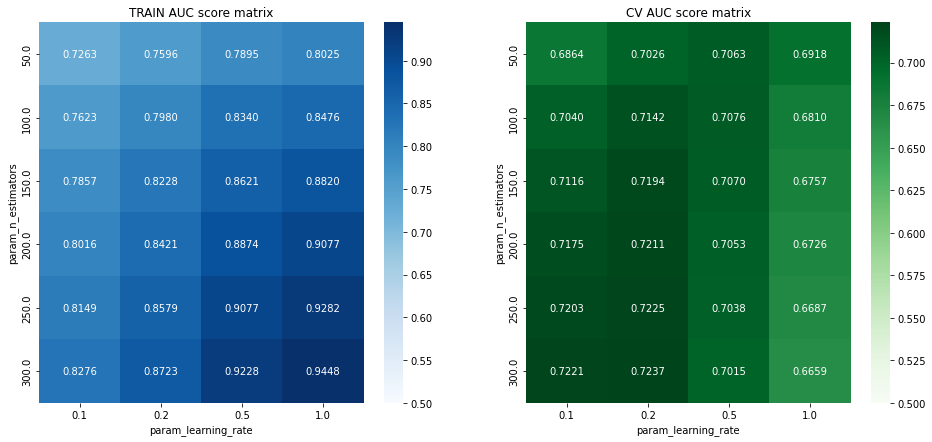

In [ ]:
# heatmap
# Plotting the performance of the model corresponding to different parameter values for the train dataset

plt.figure(figsize=(16,7))
ax= plt.subplot(1,2,1);


sns.heatmap(pivoted_train_results_set1,vmin=0.5, annot=True,ax=ax, cmap="Blues", fmt='.4f');

# labels, title and ticks
ax.set_ylim((6.0), 0)
ax.set_title('TRAIN AUC score matrix');


# heatmap
# Plotting the performance of the model corresponding to different parameter values for the train dataset

# plt.figure(figsize=(7,5))
ax= plt.subplot(1,2,2);


sns.heatmap(pivoted_test_results_set1,vmin=0.5, annot=True,ax=ax, cmap="Greens", fmt='.4f');

# labels, title and ticks
ax.set_ylim((6.0), 0)
ax.set_title('CV AUC score matrix');

In [ ]:
# best hyper-parameter : n_est = 300, learning_rate = 0.1

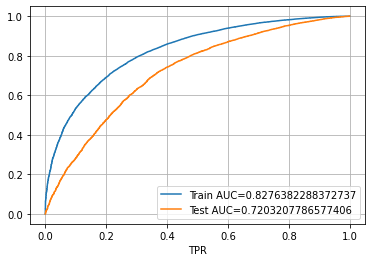

In [ ]:
# Now we are going to train our model using the best hyperparameter and then see what auc score we get on the test data
n_est = 300
lr = 0.1

gbdt = XGBClassifier(n_estimators=n_est,learning_rate=lr,booster='gbtree', n_jobs=-1)
    
gbdt.fit(X_tr_set1, y_train)       # Fitting our train data to the model

# Predict the probability output for the train data points and store the auc_score
y_train_pred = gbdt.predict_proba(X_tr_set1)[:,1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred)

y_test_pred = gbdt.predict_proba(X_te_set1)[:,1]
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.plot(train_fpr, train_tpr, label='Train AUC='+str(auc(train_fpr,train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC='+str(auc(test_fpr,test_tpr)))
plt.grid()
plt.legend()
plt.xlabel('FPR')
plt.xlabel('TPR')
plt.show();

In [ ]:
# the best threshold will be the one for which the tpr*(1-fpr) value is the maximum
def find_best_thresold(thresholds, fpr, tpr):
    t = thresholds[np.argmax(tpr*(1-fpr))]
    print(f"The best thershold for which tpr-(1-fpr) is maximum is {t}")
    return t

# This function returns the class label for a given threshold and probalbilty value 
def predict_with_best_proba(proba, threshold):
    
    predictions = []
    
    for i in proba:
        if i> threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
# Find the best threshold

best_threshold = find_best_thresold(train_thresholds, train_fpr, train_tpr)

# Print the TRAIN confusion matrix
print("Train Confusion matrix:\n",confusion_matrix(y_train, predict_with_best_proba(y_train_pred, best_threshold)))

# Print the Test confusion matrix
print("Test Confusion matrix:\n",confusion_matrix(y_test, predict_with_best_proba(y_test_pred, best_threshold)))

The best thershold for which tpr-(1-fpr) is maximum is 0.8319200873374939
Train Confusion matrix:
 [[ 6000  1940]
 [11500 32998]]
Test Confusion matrix:
 [[ 2091  1217]
 [ 5287 13255]]


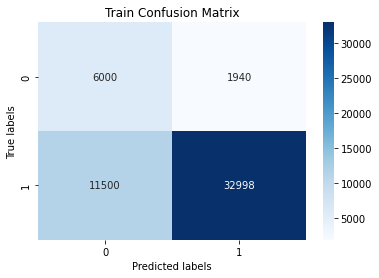

In [ ]:
# Reference : https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

# Store the confusion matrix and use it to plot the heatmap
cm=confusion_matrix(y_train, predict_with_best_proba(y_train_pred, best_threshold))

ax= plt.subplot();
sns.heatmap(cm, annot=True,cmap='Blues',ax=ax,fmt='d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Train Confusion Matrix');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);

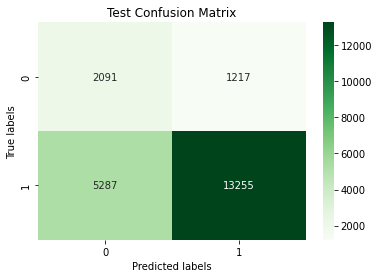

In [ ]:
# Reference : https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

# Store the confusion matrix and use it to plot the heatmap
cm=confusion_matrix(y_test, predict_with_best_proba(y_test_pred, best_threshold))

ax= plt.subplot();
sns.heatmap(cm, annot=True,cmap='Greens',ax=ax,fmt='d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Test Confusion Matrix');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);

# 1.5.2 GBDT on SET-2 Features

In [ ]:
# Stacking all the train and test data together
X_tr_set2 = np.hstack((X_train_tfidf_w2v_vectors, X_train_school_state, X_train_teacher_prefix, X_train_project_grade_category, X_train_clean_categories, X_train_clean_subcategories, X_train_price, X_train_tnoppp))
X_cv_set2 = np.hstack((X_cv_tfidf_w2v_vectors, X_cv_school_state, X_cv_teacher_prefix, X_cv_project_grade_category, X_cv_clean_categories, X_cv_clean_subcategories, X_cv_price, X_cv_tnoppp))
X_te_set2 = np.hstack((X_test_tfidf_w2v_vectors, X_test_school_state, X_test_teacher_prefix, X_test_project_grade_category, X_test_clean_categories, X_test_clean_subcategories, X_test_price, X_test_tnoppp))

In [ ]:
# These are the values of hyper-parameters we want to test for our models
n_estimators = [50,100, 150, 200,250,300]
learning_rates = [0.1, 0.2, 0.5,1]

# initializing a dataframe to store the model results
results_set2 = pd.DataFrame(columns=['param_n_estimators','param_learning_rate','mean_train_score','mean_test_score'])

for n_est in n_estimators:     # Iterate over the n_estimator parameter  
    
    for lr in learning_rates:    # Iterate over the learning rate parameter

        # Initializing our model with the parameters
        gbdt = XGBClassifier(n_estimators=n_est,learning_rate=lr,booster='gbtree', n_jobs=-1)

        gbdt.fit(X_tr_set2, y_train)       # Fitting our train data to the model

        # Predict the probability output for the train data points and store the auc_score
        y_train_pred = gbdt.predict_proba(X_tr_set2)[:,1]
        y_train_score = roc_auc_score(y_train, y_train_pred)

        # Predict the probability output for the CV data points and store the auc_score
        y_cv_pred = gbdt.predict_proba(X_cv_set2)[:,1]
        y_cv_score = roc_auc_score(y_cv, y_cv_pred)

        # Store the all the model details in the dataframe
        results_set2.loc[len(results_set2.index)] = [n_est, lr, y_train_score, y_cv_score]


In [ ]:
results_set2

,param_n_estimators,param_learning_rate,mean_train_score,mean_test_score
0,50.0,0.1,0.729449,0.691978
1,50.0,0.2,0.754837,0.701188
2,50.0,0.5,0.782350,0.694079
3,50.0,1.0,0.795051,0.672145
4,100.0,0.1,0.757523,0.702555
5,100.0,0.2,0.787748,0.704158
6,100.0,0.5,0.828221,0.692403
7,100.0,1.0,0.849038,0.664358
8,150.0,0.1,0.773811,0.704050
9,150.0,0.2,0.811645,0.705563


In [ ]:
# results_pivoted_train = results.pivot('param_max_depth','param_min_samples_split', 'mean_train_score')
# results_pivoted_train
pivoted_train_results_set2 = results_set2.pivot('param_n_estimators', 'param_learning_rate', 'mean_train_score')
pivoted_train_results_set2

param_learning_rate,0.1,0.2,0.5,1.0
param_n_estimators,,,,
50.0,0.729449,0.754837,0.782350,0.795051
100.0,0.757523,0.787748,0.828221,0.849038
150.0,0.773811,0.811645,0.860894,0.887722
200.0,0.788854,0.832830,0.888127,0.917144
250.0,0.802856,0.849423,0.909605,0.940200
300.0,0.814718,0.865180,0.927933,0.957835


In [ ]:
pivoted_test_results_set2 = results_set2.pivot('param_n_estimators', 'param_learning_rate', 'mean_test_score')
pivoted_test_results_set2

param_learning_rate,0.1,0.2,0.5,1.0
param_n_estimators,,,,
50.0,0.691978,0.701188,0.694079,0.672145
100.0,0.702555,0.704158,0.692403,0.664358
150.0,0.704050,0.705563,0.688845,0.656410
200.0,0.706475,0.704378,0.685088,0.651061
250.0,0.707555,0.703777,0.681333,0.645494
300.0,0.707880,0.702529,0.675177,0.642810


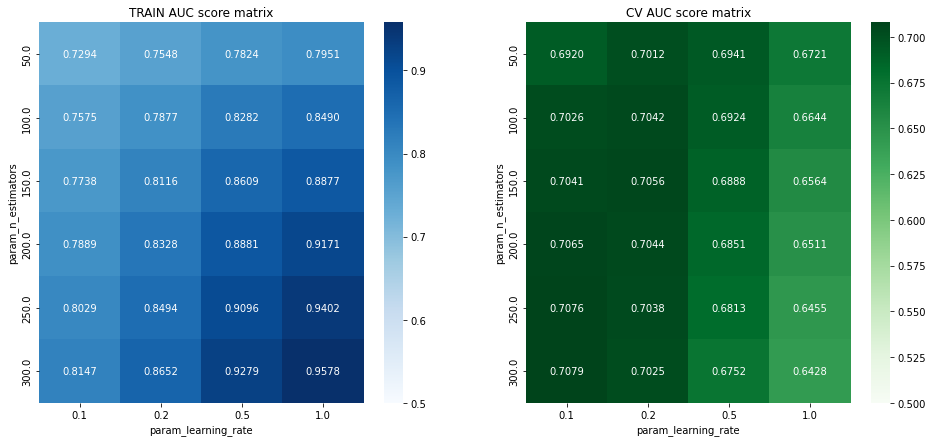

In [ ]:
# heatmap
# Plotting the performance of the model corresponding to different parameter values for the train dataset

plt.figure(figsize=(16,7))
ax= plt.subplot(1,2,1);


sns.heatmap(pivoted_train_results_set2,vmin=0.5, annot=True,ax=ax, cmap="Blues", fmt='.4f');

# labels, title and ticks
ax.set_ylim((6.0), 0)
ax.set_title('TRAIN AUC score matrix');


# heatmap
# Plotting the performance of the model corresponding to different parameter values for the train dataset

# plt.figure(figsize=(7,5))
ax= plt.subplot(1,2,2);


sns.heatmap(pivoted_test_results_set2,vmin=0.5, annot=True,ax=ax, cmap="Greens", fmt='.4f');

# labels, title and ticks
ax.set_ylim((6.0), 0)
ax.set_title('CV AUC score matrix');

In [ ]:
# from the above plot we have to select the best hyperparameter i.e for which the train and cv scores are close 
# we can see that for n_estimators = 200 and learning_rate = 0.1

## Training the model with the best hyper-parameter

In [ ]:

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

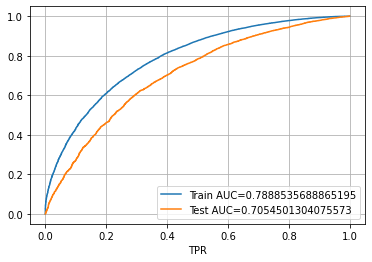

In [ ]:
# Now we are going to train our model using the best hyperparameter and then see what auc score we get on the test data
n_est = 200
lr = 0.1

gbdt = XGBClassifier(n_estimators=n_est,learning_rate=lr,booster='gbtree')
    
gbdt.fit(X_tr_set2, y_train)       # Fitting our train data to the model

# Predict the probability output for the train data points and store the auc_score
y_train_pred_set2 = gbdt.predict_proba(X_tr_set2)[:,1]
train_fpr_set2, train_tpr_set2, train_thresholds_set2 = roc_curve(y_train, y_train_pred_set2)

y_test_pred_set2 = gbdt.predict_proba(X_te_set2)[:,1]
test_fpr_set2, test_tpr_set2, test_thresholds_set2 = roc_curve(y_test, y_test_pred_set2)

# Plot the ROC curve
plt.plot(train_fpr_set2, train_tpr_set2, label='Train AUC='+str(auc(train_fpr_set2,train_tpr_set2)))
plt.plot(test_fpr_set2, test_tpr_set2, label='Test AUC='+str(auc(test_fpr_set2,test_tpr_set2)))
plt.grid()
plt.legend()
plt.xlabel('FPR')
plt.xlabel('TPR')
plt.show();

In [ ]:
# the best threshold will be the one for which the tpr*(1-fpr) value is the maximum
def find_best_thresold(thresholds, fpr, tpr):
    t = thresholds[np.argmax(tpr*(1-fpr))]
    print(f"The best thershold for which tpr*(1-fpr) is maximum is {t}")
    return t

# This function returns the class label for a given threshold and probalbilty value 
def predict_with_best_proba(proba, threshold):
    
    predictions = []
    
    for i in proba:
        if i> threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
# Find the best threshold

best_threshold = find_best_thresold(train_thresholds, train_fpr, train_tpr)

# Print the TRAIN confusion matrix
print("Train Confusion matrix:\n",confusion_matrix(y_train, predict_with_best_proba(y_train_pred, best_threshold)))

# Print the Test confusion matrix
print("Test Confusion matrix:\n",confusion_matrix(y_test, predict_with_best_proba(y_test_pred, best_threshold)))



The best thershold for which tpr-(1-fpr) is maximum is 0.8319200873374939
Train Confusion matrix:
 [[ 7237   703]
 [ 6410 38088]]
Test Confusion matrix:
 [[ 1118  2190]
 [ 6260 12282]]


## Plotting train and test confusion matrices

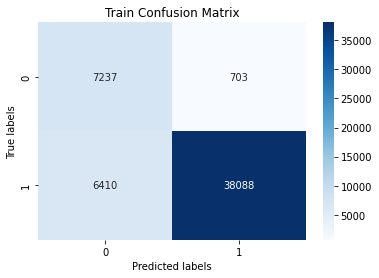

In [ ]:
# Reference : https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

# Store the confusion matrix and use it to plot the heatmap
cm=confusion_matrix(y_train, predict_with_best_proba(y_train_pred, best_threshold))

ax= plt.subplot();
sns.heatmap(cm, annot=True,cmap='Blues',ax=ax,fmt='d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Train Confusion Matrix');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);

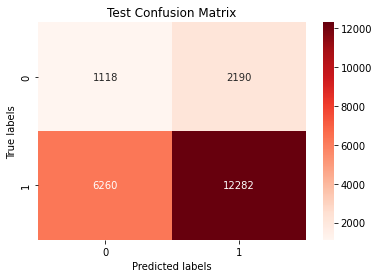

In [ ]:
# Reference : https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor

# Store the confusion matrix and use it to plot the heatmap
cm=confusion_matrix(y_test, predict_with_best_proba(y_test_pred, best_threshold))

ax= plt.subplot();
sns.heatmap(cm, annot=True,cmap='Reds',ax=ax,fmt='d');

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_ylim(2.0, 0)
ax.set_title('Test Confusion Matrix');
ax.xaxis.set_ticklabels(['0','1']); 
ax.yaxis.set_ticklabels(['0','1']);

<h1>3. Summary</h1>


In [ ]:
from prettytable import PrettyTable

In [ ]:
x = PrettyTable()
x = PrettyTable(["Vectorizer", "Model", "Hyper-parameter", "AUC"])

row = ['TF-IDF', 'GBDT', 'n_estimators=300,learning_rate=0.1', auc(test_fpr,test_tpr)]
x.add_row(row)

row = ['TFIDF_W2V', 'GBDT', 'n_estimators=200,learning_rate=0.1', auc(test_fpr_set2,test_tpr_set2)]
x.add_row(row)

print(x)

+------------+-------+------------------------------------+--------------------+
| Vectorizer | Model |          Hyper-parameter           |        AUC         |
+------------+-------+------------------------------------+--------------------+
|   TF-IDF   |  GBDT | n_estimators=300,learning_rate=0.1 | 0.7203207786577406 |
| TFIDF_W2V  |  GBDT | n_estimators=200,learning_rate=0.1 | 0.7054501304075573 |
+------------+-------+------------------------------------+--------------------+
